### Imports

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
from tqdm import tqdm
import math
import random
%matplotlib inline

### Functions

In [5]:
def build_dataset(words, block_size, stoi):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

def train(Xtr, Ytr, dim_embed, dim_w1, block_size, n_epochs=200000) -> tuple:
  g = torch.Generator().manual_seed(2147483647) # for reproducibility
  C = torch.rand((27, dim_embed), generator=g)
  W1 = torch.rand((block_size * dim_embed, dim_w1), generator=g)
  b1 = torch.rand(dim_w1, generator=g)
  W2 = torch.rand((dim_w1, 27), generator=g)
  b2 = torch.rand(27, generator=g)
  parameters = [C, W1, b1, W2, b2]
  for p in parameters:
    p.requires_grad = True

  for i in tqdm(range(n_epochs)):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, math.prod(emb.shape[1:])) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # tqdm.write(f"{loss=:.4f}")
    
    # backward pass
    for p in parameters:
      p.grad = None
    loss.backward()
    
    # update
    #lr = lrs[i]
    t = 10 ** -8
    lr = 0.1 if i < 100000 else 0.01 * (1 + i * t)
    for p in parameters:
      p.data += -lr * p.grad

    # track stats
    #lri.append(lre[i])
    # stepi.append(i)
    # lossi.append(loss.log10().item())

  print(loss.item())
  return C, W1, b1, W2, b2

def eval_loss(Xtr, Ytr, C, W1, b1, W2, b2):
  emb = C[Xtr] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, math.prod(emb.shape[1:])) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr)
  return loss.item()

### Build dataset

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

# build the dataset
block_size = 5 # context length: how many characters do we take to predict the next one?

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1], block_size, stoi)
Xdev, Ydev = build_dataset(words[n1:n2], block_size, stoi)
Xte, Yte = build_dataset(words[n2:], block_size, stoi)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
torch.Size([182625, 5]) torch.Size([182625])
torch.Size([22655, 5]) torch.Size([22655])
torch.Size([22866, 5]) torch.Size([22866])


### Explanatory code

In [ ]:
len(words)

32033

In [ ]:
# build the dataset

# block_size = 3 # context length: how many characters do we take to predict the next one?
# X, Y = [], []
# for w in words:
  
#   #print(w)
#   context = [0] * block_size
#   for ch in w + '.':
#     ix = stoi[ch]
#     X.append(context)
#     Y.append(ix)
#     #print(''.join(itos[i] for i in context), '--->', itos[ix])
#     context = context[1:] + [ix] # crop and append
  
# X = torch.tensor(X)
# Y = torch.tensor(Y)

In [ ]:
# X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [ ]:
C = torch.randn((27, 2))

In [ ]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [ ]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [ ]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [ ]:
h

tensor([[-0.9961,  0.9930, -0.5910,  ...,  0.9991, -0.9948,  0.9489],
        [-0.9802,  1.0000,  0.7359,  ...,  0.9999,  0.9999,  0.9898],
        [-0.9984,  1.0000,  0.9929,  ...,  0.7352,  0.9997, -0.7668],
        ...,
        [-0.9604, -0.9607, -0.9359,  ...,  0.9994, -0.9928,  0.7559],
        [-0.9958, -0.9804, -0.9484,  ...,  0.9976, -0.9911, -0.2395],
        [-0.1893,  0.8610, -0.6565,  ...,  0.9963, -0.9772,  0.9249]])

In [ ]:
h.shape

torch.Size([228146, 100])

In [ ]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2

In [ ]:
logits.shape

torch.Size([228146, 27])

In [ ]:
counts = logits.exp()

In [ ]:
prob = counts / counts.sum(1, keepdims=True)

In [ ]:
prob.shape, Y.shape, prob.shape[0]

(torch.Size([228146, 27]), torch.Size([228146]), 228146)

In [ ]:
loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()
loss

tensor(17.7722)

In [ ]:
# ------------ now made respectable :) ---------------

In [ ]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
lri = []
lossi = []
stepi = []

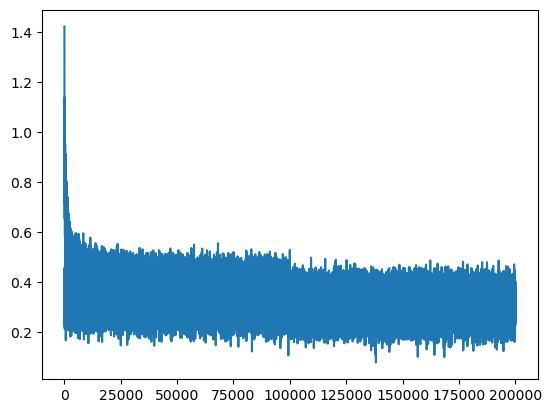

In [ ]:
plt.plot(stepi, lossi)

### Train

In [6]:
# Initial tuning: loss_val_min=2.1520. dim_embed_best=10, dim_w1_best=300, block_size_best=3
# Above parameters, using uniform initialization: loss_val_min=2.1041
# Above parameters, using normal initialization, with mean = 0.5 and std = 0.25: loss_val_min=
losses = {}
loss_val_min = float('inf')
dim_embed_best = None
dim_w1_best = None
block_size_best = None
n_epochs = 200000
for dim_embed in [10]:  # [2, 4, 8, 10]
    losses[dim_embed] = {}
    for dim_w1 in [300]:  # [10, 50, 100, 200, 500, 1000]
        for block_size in [3]:
            # Build dataset

            # read in all the words
            words = open('names.txt', 'r').read().splitlines()

            # build the vocabulary of characters and mappings to/from integers
            chars = sorted(list(set(''.join(words))))
            stoi = {s:i+1 for i,s in enumerate(chars)}
            stoi['.'] = 0
            itos = {i:s for s,i in stoi.items()}
            print(itos)

            # build the dataset
            # block_size = 5 # context length: how many characters do we take to predict the next one?

            random.seed(42)
            random.shuffle(words)
            n1 = int(0.8*len(words))
            n2 = int(0.9*len(words))

            Xtr, Ytr = build_dataset(words[:n1], block_size, stoi)
            Xdev, Ydev = build_dataset(words[n1:n2], block_size, stoi)
            Xte, Yte = build_dataset(words[n2:], block_size, stoi)

            # Train

            losses[dim_embed][dim_w1] = {}
            C, W1, b1, W2, b2 = train(Xtr, Ytr, dim_embed, dim_w1, block_size, n_epochs=n_epochs)
            print(f'{dim_embed=}, {dim_w1=}')
            loss_train = eval_loss(Xtr, Ytr, C, W1, b1, W2, b2)
            loss_val = eval_loss(Xdev, Ydev, C, W1, b1, W2, b2)
            losses[dim_embed][dim_w1]['train'] = loss_train
            losses[dim_embed][dim_w1]['val'] = loss_val
            if loss_val < loss_val_min:
                dim_embed_best = dim_embed
                dim_w1_best = dim_w1
                block_size_best = block_size
            loss_val_min = min(loss_val_min, loss_val)
            print(f'{loss_train=:.4f}, {loss_val=:.4f}, {block_size=}')
            print(f'{loss_val_min=:.4f}. {dim_embed_best=}, {dim_w1_best=}, {block_size_best=} \n')

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


100%|██████████| 200000/200000 [02:15<00:00, 1481.14it/s]


1.8755474090576172
dim_embed=10, dim_w1=300
loss_train=2.0496, loss_val=2.1053, block_size=3
loss_val_min=2.1053. dim_embed_best=10, dim_w1_best=300, block_size_best=3 



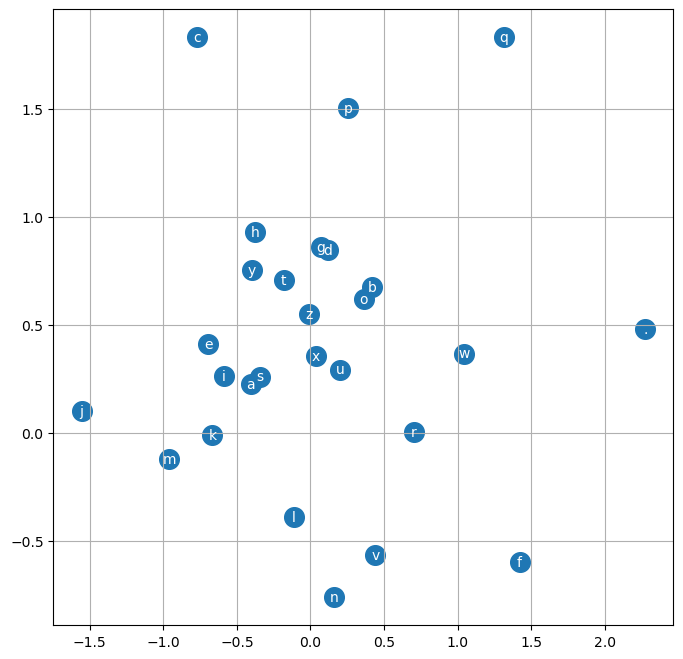

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [ ]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
amelle.
khyrilli.
taty.
skanden.
jazhitlangelynn.
kaeli.
ner.
kiah.
maiir.
kaleigh.
ham.
pris.
quint.
shoilea.
jadbi.
wajero.
dearisi.
jaxen.
drraylen.


### Exercises

- E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2

_Answer_: The tunned hyperparameters yielded a validation loss of 2.15

- E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

_Answer_: (1) With uniform initialization probability, I obtain a loss of 2.1 (< 2.2).

          (2) With mu = sigma = 0.5 I obtain a loss of 2.12.

- E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

_Answer_: I used the formula 0.01 / (1 + epoch * 10 ** -8) for learning rate decay, obtaining a slightly worse loss of 2.11.

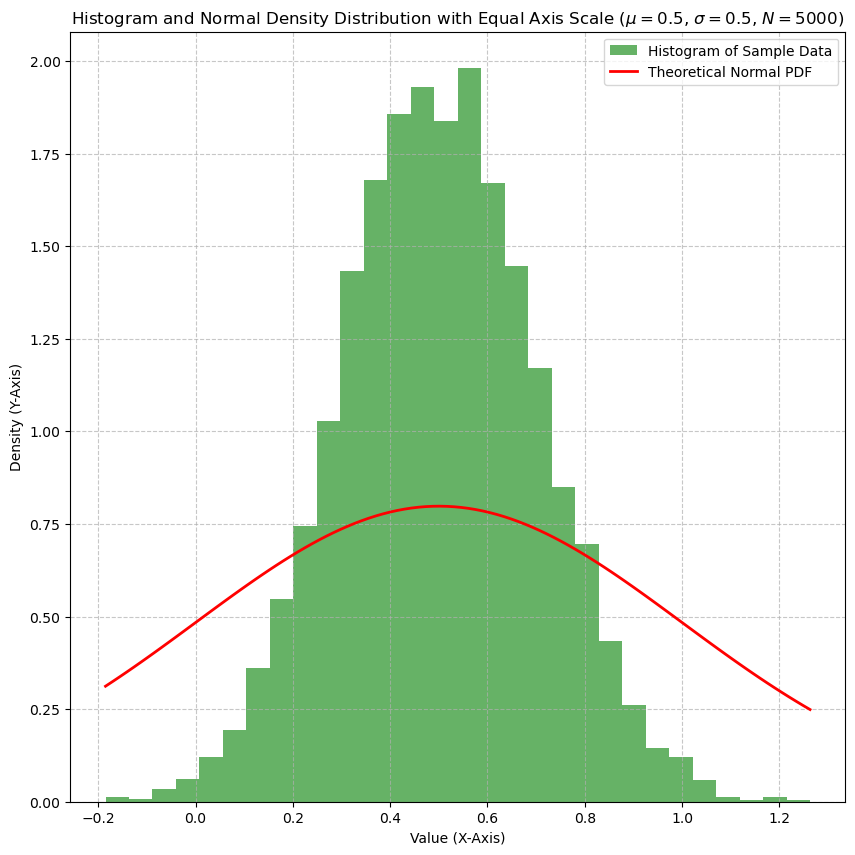

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 1. Parameters for the Normal Distribution 
mu = 0.5  # Mean (µ)
sigma = 0.5  # Standard deviation (σ)
sample_size = 5000

# 2. Generate the sample
np.random.seed(42) 
# data = np.random.normal(mu, sigma, sample_size)
data = 0.2 * torch.randn((sample_size, )) + 0.5

# 3. Create the figure and axes
# Set figure size to be square (10x10) to enforce equal visual scale
plt.figure(figsize=(10, 10)) 

# 4. Plot the histogram
plt.hist(data, bins=30, density=True, alpha=0.6, color='g', 
         label='Histogram of Sample Data')

# 5. Plot the theoretical PDF curve
# Generate x-values across the range of the sample data
xmin, xmax = data.min(), data.max()
x = np.linspace(xmin, xmax, 100)

# Calculate the theoretical PDF values 
pdf = norm.pdf(x, mu, sigma)

plt.plot(x, pdf, 'r-', linewidth=2, label='Theoretical Normal PDF')

# 6. Add labels, title, and legend
plt.title(f'Histogram and Normal Density Distribution with Equal Axis Scale ($\mu={mu}$, $\sigma={sigma}$, $N={sample_size}$)')
plt.xlabel('Value (X-Axis)')
plt.ylabel('Density (Y-Axis)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# 7. Display/Save the plot
plt.show()